<a href="https://colab.research.google.com/github/Axeka379/text-mining/blob/main/PLTweetClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment classification for teams in Premier league regarding VAR

In [ ]:
  from google.colab import drive
  from google.colab import files #For saveing files
  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re


train_path = "/content/drive/MyDrive/text-mining/sts_gold_tweet.csv"
other_path = "/content/drive/MyDrive/text-mining/modified_tweets.csv"

train_df = pd.read_csv(train_path, sep=";")

#Removing unwanted columns
train_df = train_df.filter(['polarity', 'tweet']).rename(columns={"tweet":"text"})

print(train_df.columns)

Index(['polarity', 'text'], dtype='object')


In [ ]:
#print(['team'].value_counts().plot(kind='bar'))
#plt.show()

print(train_df.shape)
print(train_df['polarity'].value_counts())

(2034, 2)
0    1402
4     632
Name: polarity, dtype: int64


The tweets distributed for each team for the period being worked on.





AxesSubplot(0.125,0.125;0.775x0.755)


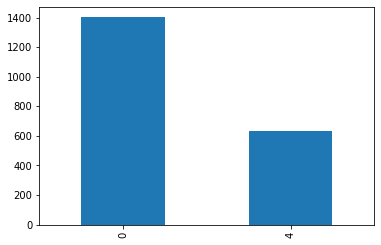

In [ ]:
print(train_df['polarity'].value_counts().plot(kind="bar"))
plt.show()

The polarity distribution for the training dataset.


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

#Global stop words
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 
from html import unescape


#Clean twitter text
def clean_tweet(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text() 
    text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = remove_emojis(text)
    
    text_tokens = word_tokenize(text)
    filtered_words = [w for w in text_tokens if not w in stop_words]

    #lemmatizer = WordNetLemmatizer()
    #filtered_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    ps = PorterStemmer()
    filtered_words = [ps.stem(w) for w in filtered_words]

    return " ".join(filtered_words)

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

def get_feature_vector(data):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(data)
    #print("in get feature")
    #print(len(vector.idf_))
    return vector



In [ ]:
#def train_classifier(the_set):

  #
  #Getting a training and test set for the STS_tweets, just for measurement.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# the_set.text = the_set['text'].apply(clean_tweet)
the_set = train_df
the_set.text = the_set["text"].apply(clean_tweet)
tf_vector = get_feature_vector(np.array(the_set.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(the_set.iloc[:, 1]).ravel())
Y = np.array(the_set.iloc[:, 0]).ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

#Naive bayes

nb_clf = MultinomialNB()
nb_clf.fit(X_train, Y_train)
predict_nb = nb_clf.predict(X_test)
print(accuracy_score(Y_test, predict_nb))


0.742014742014742


In [ ]:
estimator=MultinomialNB()
parameters = {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'fit_prior': [True, False]}
print(estimator.get_params().keys())

grid_search = GridSearchCV(estimator, parameters, cv=5)
grid_search.fit(X_train, Y_train)

#print(accuracy_score(Y_test, y_predict_lr))
print("Best score: "+str(grid_search.best_score_))
print("Best parameters:"+str(grid_search.best_params_))

dict_keys(['alpha', 'class_prior', 'fit_prior'])
Best score: 0.818669183577159
Best parameters:{'alpha': 1, 'fit_prior': False}


In [ ]:

# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs', C=100.0, multi_class='ovr', max_iter = 1000000)
LR_model.fit(X_train, Y_train)
#parameters = {'multi_class': ["ovr"], 'C': [1, 10, 100], "solver": ['liblinear', 'lbfgs'], 'max_iter':[1, 10, 100, 1000, 10000, 100000]}
y_predict_lr = LR_model.predict(X_test)
print("Accuracy with some good params: ", accuracy_score(Y_test, y_predict_lr))
print(classification_report(Y_test, y_predict_lr))

'''
print(LR_model.get_params().keys())
grid_search = GridSearchCV(LR_model, parameters, cv=5)

grid_search.fit(X_train, Y_train)
print("Best score: "+str(grid_search.best_score_))
print("Best parameters:"+str(grid_search.best_params_))
pred = grid_search.predict(X_test)
'''

Accuracy with some good params:  0.828009828009828
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       278
           4       0.84      0.57      0.68       129

    accuracy                           0.83       407
   macro avg       0.83      0.76      0.78       407
weighted avg       0.83      0.83      0.82       407



'\nprint(LR_model.get_params().keys())\ngrid_search = GridSearchCV(LR_model, parameters, cv=5)\n\ngrid_search.fit(X_train, Y_train)\nprint("Best score: "+str(grid_search.best_score_))\nprint("Best parameters:"+str(grid_search.best_params_))\npred = grid_search.predict(X_test)\n'

In [ ]:
#Training Random Forest

'''
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

parameters = {'max_depth': [1, 10, 100, 1000], 'n_estimators': [1, 10, 100, 1000]}

print(clf.get_params().keys())
grid_search = GridSearchCV(clf, parameters, cv=5)

grid_search.fit(X_train, Y_train)
print("Best score: "+str(grid_search.best_score_))
print("Best parameters:"+str(grid_search.best_params_))
#print(classification_report(Y_test, y_predict_lr))

'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nclf = RandomForestClassifier()\nclf.fit(X_train, Y_train)\n\nparameters = {\'max_depth\': [1, 10, 100, 1000], \'n_estimators\': [1, 10, 100, 1000]}\n\nprint(clf.get_params().keys())\ngrid_search = GridSearchCV(clf, parameters, cv=5)\n\ngrid_search.fit(X_train, Y_train)\nprint("Best score: "+str(grid_search.best_score_))\nprint("Best parameters:"+str(grid_search.best_params_))\n#print(classification_report(Y_test, y_predict_lr))\n\n'

In [ ]:
#small code snippet to convert the sentiment values to text form. Might be useful later
def int_to_string(sentiment): 
    if(sentiment == 0):
        return "Negative"
    else:
        return "Positive"

In [ ]:
df = pd.read_csv(other_path)
df = df.filter(['file_name', 'text']).rename(columns={"file_name":"team"})

df.text = df.text.apply(clean_tweet)
#print(df.iloc[:, 1])
#print()


In [ ]:
#tf_vector = get_feature_vector(np.array(df.iloc[:, 1]).ravel())
print(df.iloc[:, 1])
print(the_set.iloc[:, 1])
transformed_df = tf_vector.transform(np.array(df.iloc[:, 1]).ravel())



0       I think vardi lucki boy what weve seen inconsi...
1       icymi We plu size episod week cover 3 game wel...
2       bruno prove var never brought profootbal make ...
3       whi dont see var offici ill tell arent actual ...
4       tonight var verdict bruno fernand vs A villa p...
                              ...                        
2556    brilliant goal leicest rule offsid var leiwhu ...
2557                                even var give us lcfc
2558    903 actual the goal chalk offsid var 03 lcfc w...
2559                       yep var look leiwhu lcfc whufc
2560    just post eric malpu premier leagu result var ...
Name: text, Length: 2561, dtype: object
0                            angel go miss athlet weekend
1       It look though shaq get trade cleveland play w...
2                         april 9th isnt come soon enough
3       drink mcdonald coffe understand someon would h...
4               So dissapoint taylor swift doesnt twitter
                              ..

In [ ]:

prediction = LR_model.predict(transformed_df)

result_ds = pd.DataFrame({'text': df.text, 'team':df.team, 'prediction':prediction})
#result = result_ds.groupby(['team'])
result_ds.columns = ['text', 'team', 'prediction']
result_ds.prediction = result_ds['prediction'].apply(int_to_string)







AxesSubplot(0.125,0.125;0.775x0.755)


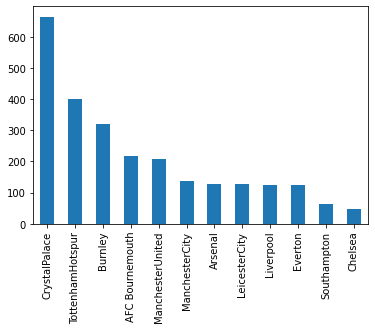

In [ ]:
print(result_ds['team'].value_counts().plot(kind="bar"))

AxesSubplot(0.125,0.125;0.775x0.755)
Negative    2047
Positive     514
Name: prediction, dtype: int64


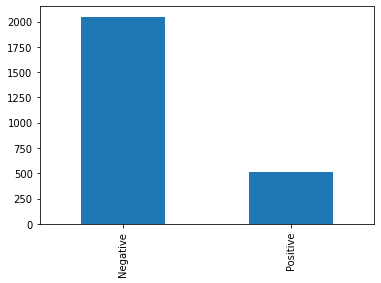

In [ ]:
print(result_ds['prediction'].value_counts().plot(kind="bar"))
print(result_ds['prediction'].value_counts())


In [ ]:
#one_teamresult_ds['team'].tolist()

teams_list = result_ds['team'].unique().tolist()
print(teams_list)




In [ ]:
def print_plot(teamname):
  plt.title(team_df.team.unique()[0])
  #plt.savefig(teamname + ".png")
  #files.download(teamname+'.png') 
  plt.show()


AxesSubplot(0.125,0.125;0.775x0.755)
['LeicesterCity']
Negative:  90
Positive:  37
127


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

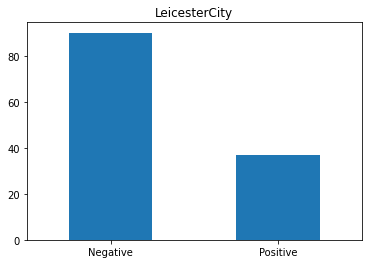

AxesSubplot(0.125,0.125;0.775x0.755)
['Everton']
Negative:  108
Positive:  17
125


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

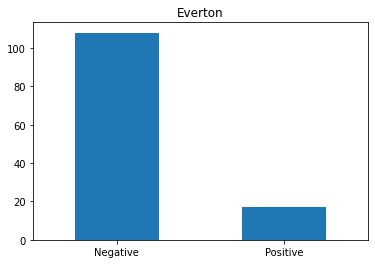

AxesSubplot(0.125,0.125;0.775x0.755)
['ManchesterCity']
Negative:  102
Positive:  35
137


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

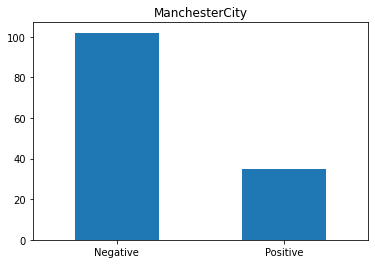

AxesSubplot(0.125,0.125;0.775x0.755)
['Arsenal']
Negative:  105
Positive:  23
128


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

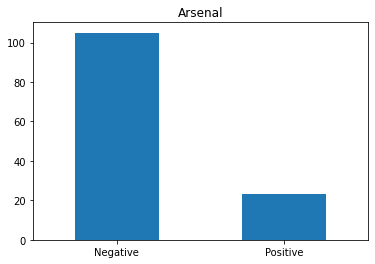

AxesSubplot(0.125,0.125;0.775x0.755)
['AFC Bournemouth']
Negative:  188
Positive:  30
218


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

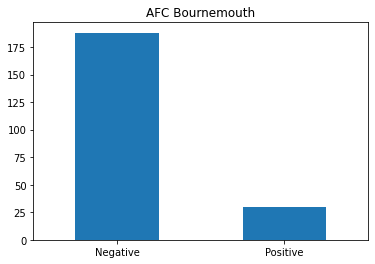

AxesSubplot(0.125,0.125;0.775x0.755)
['Burnley']
Negative:  260
Positive:  59
319


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

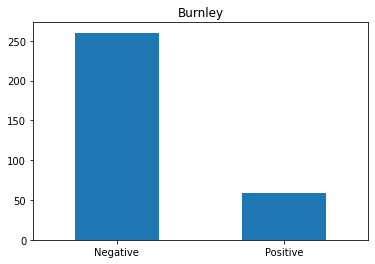

AxesSubplot(0.125,0.125;0.775x0.755)
['CrystalPalace']
Negative:  538
Positive:  126
664


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

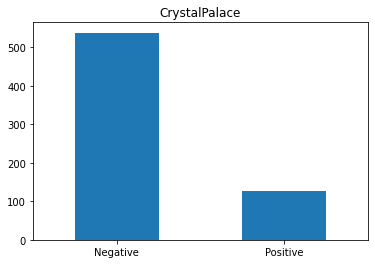

AxesSubplot(0.125,0.125;0.775x0.755)
['Chelsea']
Negative:  9
Positive:  37
46


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

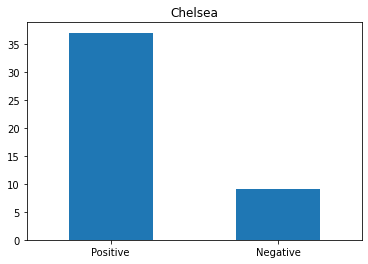

AxesSubplot(0.125,0.125;0.775x0.755)
['TottenhamHotspur']
Negative:  335
Positive:  66
401


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

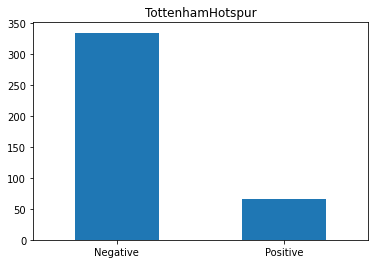

AxesSubplot(0.125,0.125;0.775x0.755)
['ManchesterUnited']
Negative:  168
Positive:  39
207


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

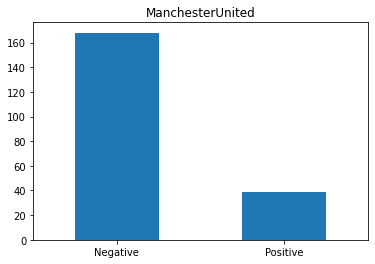

AxesSubplot(0.125,0.125;0.775x0.755)
['Liverpool']
Negative:  98
Positive:  28
126


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

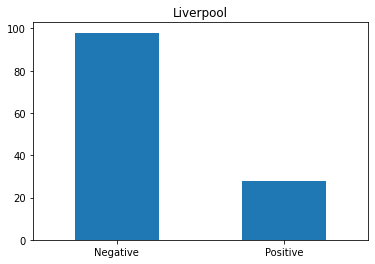

AxesSubplot(0.125,0.125;0.775x0.755)
['Southampton']
Negative:  46
Positive:  17
63


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

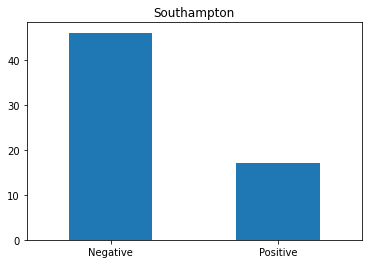

In [ ]:
i = 0
neg_prc_list = []
for index in teams_list:
  team_df = pd.DataFrame(columns = result_ds.columns)

  #print(team_sentiment)
  for index, row in result_ds.iterrows():
      if(row['team'] == teams_list[i]):
        team_df = team_df.append(row, ignore_index=True)

  print(team_df['prediction'].value_counts().plot(kind="bar", rot=0))
  print(team_df['team'].unique())
  team_sent = team_df['prediction'].value_counts()
  #print(test)
  neg_prc = (team_sent['Negative']/(team_sent['Negative']+team_sent['Positive']))
  neg_prc_list.append([team_df['team'].unique(), neg_prc])
  print("Negative: ", team_sent['Negative'])
  print("Positive: ", team_sent['Positive'])

  print(team_sent[0]+team_sent[1])

  print_plot(str(team_df.team.unique()[0]))
  
  i+=1

In [ ]:
print(neg_prc_list)

for team in neg_prc_list:
  print(team[0]," ", team[1])


[[array(['LeicesterCity'], dtype=object), 0.7086614173228346], [array(['Everton'], dtype=object), 0.864], [array(['ManchesterCity'], dtype=object), 0.7445255474452555], [array(['Arsenal'], dtype=object), 0.8203125], [array(['AFC Bournemouth'], dtype=object), 0.8623853211009175], [array(['Burnley'], dtype=object), 0.8150470219435737], [array(['CrystalPalace'], dtype=object), 0.8102409638554217], [array(['Chelsea'], dtype=object), 0.1956521739130435], [array(['TottenhamHotspur'], dtype=object), 0.8354114713216958], [array(['ManchesterUnited'], dtype=object), 0.8115942028985508], [array(['Liverpool'], dtype=object), 0.7777777777777778], [array(['Southampton'], dtype=object), 0.7301587301587301]]
['LeicesterCity']   0.7086614173228346
['Everton']   0.864
['ManchesterCity']   0.7445255474452555
['Arsenal']   0.8203125
['AFC Bournemouth']   0.8623853211009175
['Burnley']   0.8150470219435737
['CrystalPalace']   0.8102409638554217
['Chelsea']   0.1956521739130435
['TottenhamHotspur']   0.8354